<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2025/blob/main/notebooks/es20.3/Ising_wt_numba_pre_allocation_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from numba import njit

# -----------------------------------------------------------------------------
# Metropolis step functions (optimized with numba)
# -----------------------------------------------------------------------------

@njit
def metropolis_step(lattice, beta, L,rands):
    """
    Perform one Metropolis sweep on the lattice (L^2 spin flip attempts).

    Parameters:
    - lattice: 2D numpy array of spins (+1 or -1)
    - beta: inverse temperature (1/T)
    - L: size of the lattice (assumed square: L x L)

    Returns:
    - Updated lattice configuration after one sweep.
    """
    for r in range(L * L):
        # Choose a random site
        i = int(rands[r,0] * L)#np.random.randint(0, L)
        j = int(rands[r,1] * L)#np.random.randint(0, L)

        # Sum of nearest neighbor spins with periodic boundary conditions
        up    = lattice[(i - 1) % L, j]
        down  = lattice[(i + 1) % L, j]
        left  = lattice[i, (j - 1) % L]
        right = lattice[i, (j + 1) % L]

        # Energy change ΔE = 2 * s_ij * (sum of neighbors)
        dE = 2 * lattice[i, j] * (up + down + left + right)

        # Accept flip if energy is lowered or with Boltzmann probability
        if dE < 0:
            lattice[i, j] = -lattice[i, j]
        else:
            if rands[r,2] < np.exp(-beta * dE):
                lattice[i, j] = -lattice[i, j]
    return lattice

@njit
def metropolis_step_zero_temperature(lattice, L):
    """
    Perform one Metropolis sweep optimized for zero temperature.
    At T = 0, a spin is flipped only if the move decreases the energy.

    Parameters:
    - lattice: 2D numpy array of spins (+1 or -1)
    - L: size of the lattice

    Returns:
    - Updated lattice configuration after one sweep.
    """
    for _ in range(L * L):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        up    = lattice[(i - 1) % L, j]
        down  = lattice[(i + 1) % L, j]
        left  = lattice[i, (j - 1) % L]
        right = lattice[i, (j + 1) % L]

        dE = 2 * lattice[i, j] * (up + down + left + right)

        if dE < 0:
            lattice[i, j] = -lattice[i, j]
    return lattice

# -----------------------------------------------------------------------------
# Observable calculation functions
# -----------------------------------------------------------------------------

@njit
def compute_magnetization(lattice):
    """
    Compute the magnetization of the lattice (average spin value).

    Parameters:
    - lattice: 2D numpy array of spins.

    Returns:
    - Magnetization as a float.
    """
    return np.sum(lattice) / lattice.size

@njit
def compute_entropy(lattice):
    """
    Estimate the entropy of the configuration using the Shannon entropy
    of the spin distribution. This calculates entropy based on the fraction
    of up (+1) and down (-1) spins.

    Parameters:
    - lattice: 2D numpy array of spins.

    Returns:
    - Entropy as a float.
    """
    L = lattice.shape[0]
    total = L * L
    count_up = 0
    count_down = 0

    for i in range(L):
        for j in range(L):
            if lattice[i, j] == 1:
                count_up += 1
            else:
                count_down += 1

    p_up = count_up / total
    p_down = count_down / total

    entropy = 0.0
    if p_up > 0:
        entropy -= p_up * math.log(p_up)
    if p_down > 0:
        entropy -= p_down * math.log(p_down)

    return entropy
####
@njit
def simulation_loop(n_steps ,lattice,temperature,grid_size,seed_ising):
  # Simulation loop
  magnetizations = np.empty(n_steps)
  entropies = np.empty(n_steps)

# Precompute beta (inverse temperature) for T > 0
  if temperature > 0:
      beta = 1.0 / temperature
  else:
      beta = 0.0  # Not used in T=0 case


  if temperature == 0:

    for step in range(n_steps):
      lattice = metropolis_step_zero_temperature(lattice, grid_size)
  else:
    #rng = np.random.default_rng(seed_ising)
    # Generate random numbers using the generator
    np.random.seed(seed_ising)
    #rands = rng.random((n_steps,grid_size*grid_size,3))
    rands = np.random.rand(n_steps,grid_size*grid_size,3)# legacy
    for step in range(n_steps):
      lattice = metropolis_step(lattice, beta, grid_size,rands[step])

      magnetizations[step] = compute_magnetization(lattice)
      entropies[step] = 0.0#compute_entropy(lattice)
  return lattice, magnetizations, entropies
# -----------------------------------------------------------------------------
# Main simulation function (with overall time measurement)
# -----------------------------------------------------------------------------

def ising_simulation(grid_size, temperature, n_steps, initial_state=None,seed_ising=0):
    """
    Simulate a 2D Ising model using the Metropolis algorithm.

    Parameters:
    - grid_size: int, size of the lattice (grid_size x grid_size).
    - temperature: float, simulation temperature. If set to 0, the optimized
                   zero-temperature algorithm is used.
    - n_steps: int, number of simulation sweeps (each sweep has L^2 flip attempts).
    - initial_state: optional numpy array of shape (grid_size, grid_size) containing
                     initial spins (+1 or -1). If None, a random configuration is used.

    Returns:
    - final_lattice: final lattice configuration.
    - magnetizations: numpy array of magnetization values at each step.
    - entropies: numpy array of entropy values at each step.
    - total_time: float, total time taken for the simulation.
    """
    # Initialize lattice: random if initial_state is not provided.
    if initial_state is None:
        lattice = np.random.choice(np.array([-1, 1]), size=(grid_size, grid_size))
    else:
        lattice = initial_state.copy()

    magnetizations = np.empty(n_steps)
    entropies = np.empty(n_steps)


    # Start total simulation timer
    start_simulation = time.time()

    # Simulation loop
    lattice, magnetizations, entropies = simulation_loop(n_steps ,lattice,temperature,grid_size,seed_ising = seed_ising)

    total_time = time.time() - start_simulation
    return lattice, magnetizations, entropies, total_time

# -----------------------------------------------------------------------------
# Reporting and plotting functions
# -----------------------------------------------------------------------------

def report_results(final_config, magnetizations, entropies, total_time, n_steps):
    """
    Generate a report with plots:
    - Left panel: final lattice configuration.
    - Right panel: magnetization and entropy vs simulation steps.
    Also displays the total simulation time and average time per step.

    Parameters:
    - final_config: 2D numpy array of final lattice spins.
    - magnetizations: numpy array of magnetization values per step.
    - entropies: numpy array of entropy values per step.
    - total_time: float, total time taken for the simulation.
    - n_steps: int, number of simulation steps.
    """
    avg_time = total_time / n_steps

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Panel 1: Display final lattice configuration
    axs[0].imshow(final_config, cmap='gray')
    axs[0].set_title("Final Configuration")
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    # Panel 2: Plot magnetization and entropy vs steps
    steps = np.arange(1, len(magnetizations) + 1)
    axs[1].plot(steps, magnetizations, label="Magnetization")
    axs[1].plot(steps, entropies, label="Entropy")
    axs[1].set_xlabel("Simulation Step")
    axs[1].set_title("Observables vs Step")
    axs[1].legend()

    fig.suptitle(f"Simulation Report\nAverage step time: {avg_time:.6f} s, Total time: {total_time:.3f} s")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# -----------------------------------------------------------------------------
# Function to measure overlap between states
# -----------------------------------------------------------------------------

def compute_overlap(state1, state2):
    """
    Compute the overlap between two spin configurations.
    Overlap is defined as the normalized dot product of the two states.
    For ±1 spins, if the states are identical the overlap is 1; if they are opposite, -1.

    Parameters:
    - state1: numpy array of spins (+1 or -1).
    - state2: numpy array of spins, same shape as state1.

    Returns:
    - overlap: float, normalized overlap value.
    """
    return np.sum(state1 * state2) / state1.size


In [2]:
import concurrent.futures
def run_simulation_instance(params):
    """
    Run a single instance of the simulation.

    Parameters:
    - params: a dictionary containing simulation parameters.

    Returns:
    - A tuple with the simulation id and simulation results.
    """
    simulation_id = params["simulation_id"]
    # Set simulation parameters
    grid_size = params["grid_size"]
    temperature = params["temperature"]
    n_steps = params["n_steps"]
    # Create an initial configuration (different for each instance)
    initial_state = params["initial_state"]
    seed_ising = params["seed_ising"]
    # Run the simulation and get the results
    #print(seed_ising)
    start = time.time()
    final_config, mags, ents, total_time = ising_simulation(
        grid_size, temperature, n_steps, initial_state=initial_state,seed_ising=seed_ising
    )
    end = time.time()
    overall_time = end - start  # overall wall-clock time for this simulation instance
    return simulation_id, final_config, mags, ents, total_time, overall_time

In [3]:
!nproc

2


Simulation 0:
   Total simulation time (sum of steps): 17.3675 s
   overhead + simulation: 17.3676 s


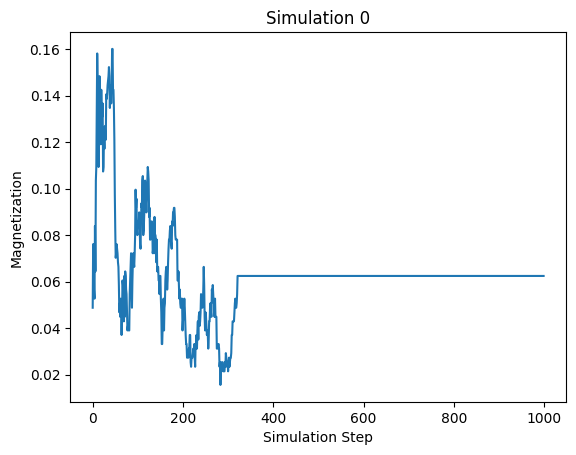

Simulation 1:
   Total simulation time (sum of steps): 17.6937 s
   overhead + simulation: 17.6938 s


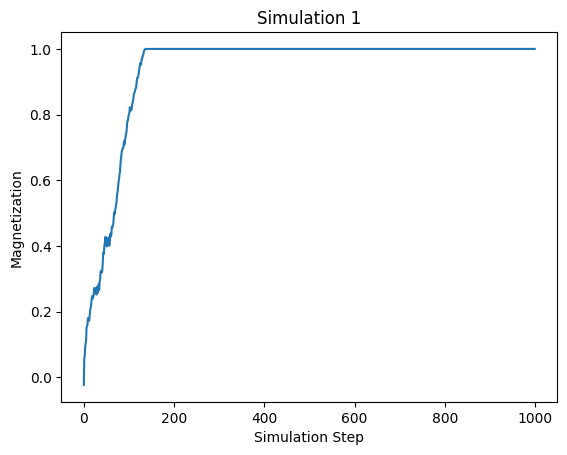

Simulation 2:
   Total simulation time (sum of steps): 0.1227 s
   overhead + simulation: 0.1228 s


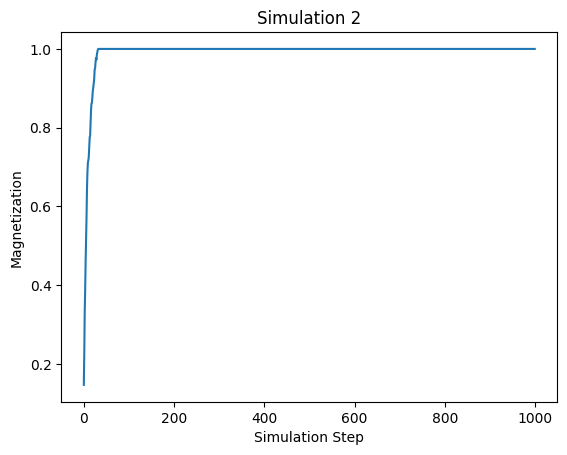

Simulation 3:
   Total simulation time (sum of steps): 0.1025 s
   overhead + simulation: 0.1026 s


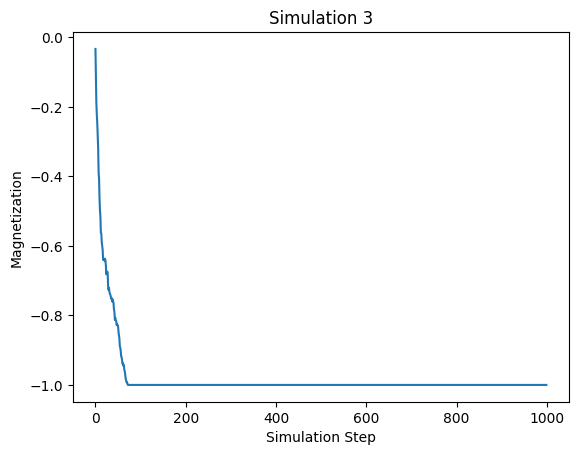

Simulation 4:
   Total simulation time (sum of steps): 0.1065 s
   overhead + simulation: 0.1066 s


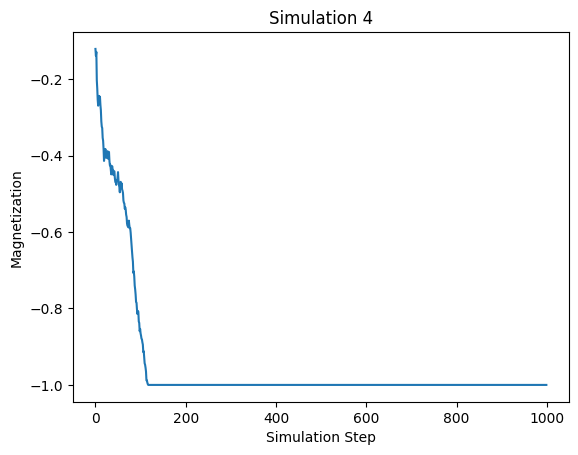

Simulation 5:
   Total simulation time (sum of steps): 0.1063 s
   overhead + simulation: 0.1064 s


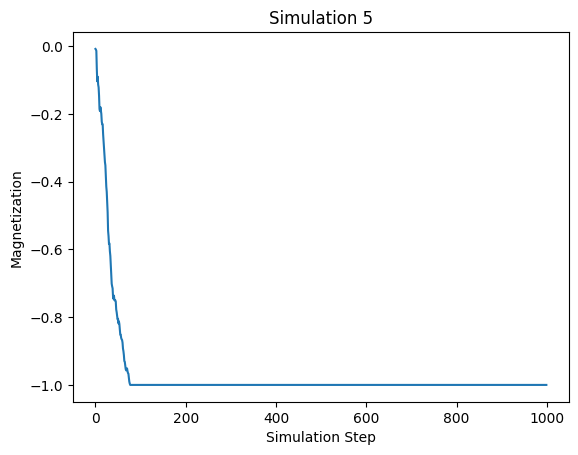

Simulation 6:
   Total simulation time (sum of steps): 0.1248 s
   overhead + simulation: 0.1249 s


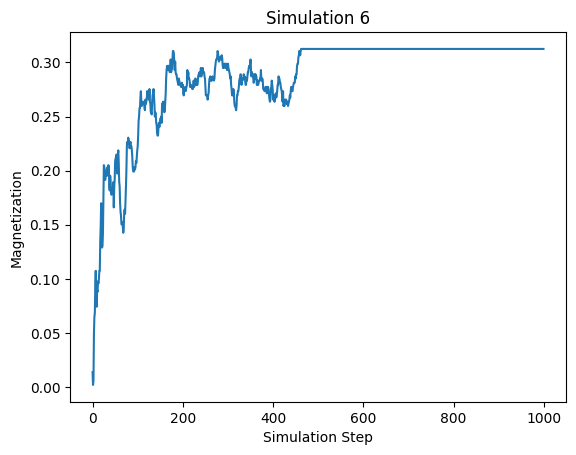

Simulation 7:
   Total simulation time (sum of steps): 0.1107 s
   overhead + simulation: 0.1107 s


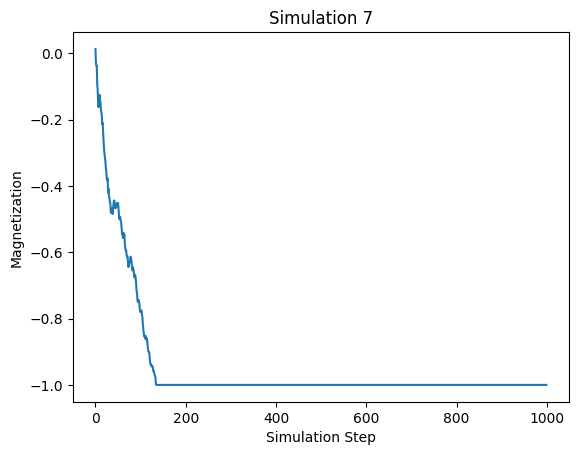

Simulation 8:
   Total simulation time (sum of steps): 0.1586 s
   overhead + simulation: 0.1587 s


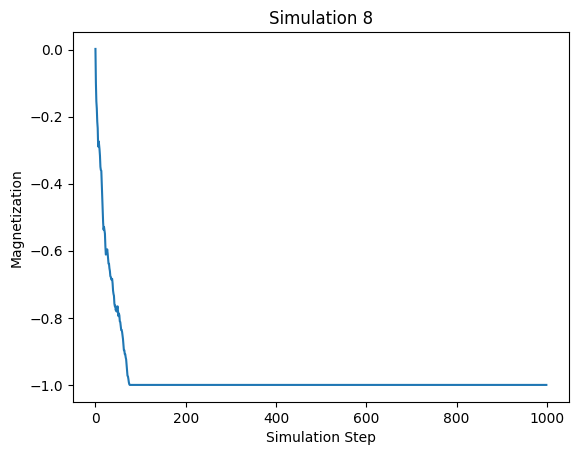

Simulation 9:
   Total simulation time (sum of steps): 0.1121 s
   overhead + simulation: 0.1121 s


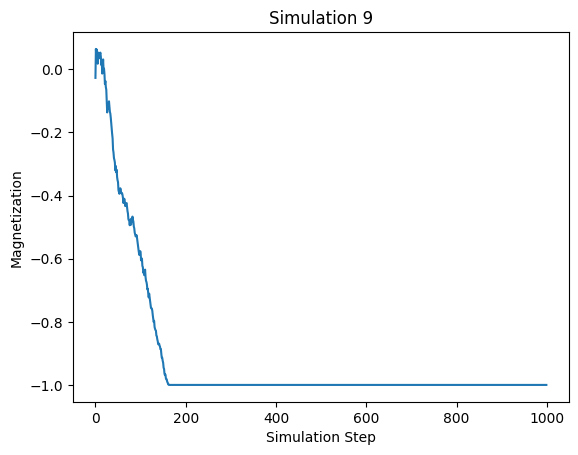

In [4]:
if __name__ == "__main__":
    n_copies = 1000  # Number of parallel simulations
    grid_size = 32
    results = []
    params_list =[{
    "initial_state" : np.random.choice(np.array([-1, 1]), size=(grid_size, grid_size)),
    "seed_ising" : np.random.randint(0, 2**32 - 1),
    "temperature": 0.1,
    "grid_size": grid_size,
    "n_steps": 1000,
    "simulation_id": i}
     for i in range(n_copies)]

    # Use ProcessPoolExecutor to run simulations in parallel
    with concurrent.futures.ProcessPoolExecutor() as executor:
        # Map the simulation function over simulation ids
        for result in executor.map(run_simulation_instance, params_list):
            results.append(result)

    # Process and print the results
    for sim_id, final_config, mags, ents, sim_total_time, overall_time in results[:10]:
        print(f"Simulation {sim_id}:")
        print(f"   Total simulation time (sum of steps): {sim_total_time:.4f} s")
        print(f"   overhead + simulation: {overall_time:.4f} s")
        #plt.imshow(final_config, cmap='gray')
        plt.plot(mags)
        plt.xlabel("Simulation Step")
        plt.ylabel("Magnetization")
        plt.title(f"Simulation {sim_id}")
        plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Example data: three lists of numerical values
data1 = np.array(baseline).astype(float)
data2 = np.array(preallocation_rand).astype(float)

data3 = np.array(numba)[1:].astype(float)


# Ensemble names for each list
ensemble_names = ['Baseline', 'Memory preallocation', 'Numba']

# Combine the data into one list for the boxplot function
data = [data1, data2, data3]

# Define a custom color palette
colors = ['#4E79A7', '#F28E2B', '#E15759']

# Create the figure and axis
plt.figure(figsize=(8, 6))
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')

# Create boxplot with patch_artist=True to allow color filling
bp = plt.boxplot(data, patch_artist=True, labels=ensemble_names,
                 boxprops=boxprops, medianprops=medianprops)

# Apply the custom color palette to each box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Adding titles and labels
plt.title('computation time L=32 1000 steps', fontsize=16)
plt.xlabel('code', fontsize=14)
plt.ylabel('seconds (log scale)', fontsize=14)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
